## Filtros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.filters import bk_filter, hp_filter, cf_filter
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter("ignore")

%run "../utils.py"

Importando serie del PBI

In [10]:
df = get_data(
    {
        "PN02538AQ": "pbi"
    },
    fechaini = "1989Q3",
    fechafin = "2020Q2"
).to_timestamp()

df = np.log(df)

### Filtros
Existe diferentes formas de filtrar una serie. Las que van a ser realizadas en esta seccion son las siguientes:
* Desestacionalizacion: ARIMA X13
* Modelo lineal
* Ucarima
* Filtro Hodrick-Prescott 
* Filtro Baxter-King
* Filtro Christiano-Fitzgerald

Hacia adelante se trabajara con la serie desestacionalizada por lo que:

In [11]:
desest = seasonal_decompose(df, model="multiplicative")

df["pbi_sa"] = desest.trend
df = df.dropna()

Es importante incluir una tendencia

In [12]:
df["trend"] = range(len(df))
df["trend"] = df["trend"] + 1
df

,pbi,pbi_sa,trend
1990-01-01,10.432188,10.525852,1
1990-04-01,10.513254,10.511934,2
1990-07-01,10.499288,10.530360,3
1990-10-01,10.601482,10.556187,4
1991-01-01,10.582646,10.570772,5
...,...,...,...
2018-10-01,11.829360,11.821777,116
2019-01-01,11.835105,11.819252,117
2019-04-01,11.876294,11.769773,118
2019-07-01,11.716217,11.713760,119


In [14]:
X = df.trend
y = df["pbi_sa"]

#### 1. Modelo Lineal (OLS)

In [15]:
X = sm.add_constant(X)
modelo_lineal = sm.OLS(y, X).fit()
print(modelo_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:                 pbi_sa   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     6983.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):          7.64e-107
Time:                        16:26:30   Log-Likelihood:                 183.08
No. Observations:                 120   AIC:                            -362.2
Df Residuals:                     118   BIC:                            -356.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4887      0.010   1075.805      0.0

In [16]:
y_ols = modelo_lineal.predict(X)
y_ols_resid = y - y_ols


df["ols_hat"] = y_ols
df["ols_resid"] = y_ols_resid

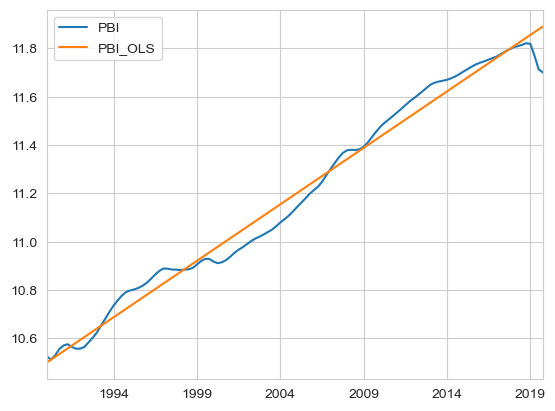

In [17]:
plt.figure()

y.plot(label="PBI")
df.ols_hat.plot(label="PBI_OLS")
plt.legend()

plt.show()

#### 2. Ucarima
El modelo Ucarima se estima mediante un ARIMA de la siguiente manera:
$$ Y_t = \mu_t +\eta_t $$
$$ \mu_{t+1} = \mu_t + \epsilon_{t+1}$$

Donde, $\mu_t$ es la tendencia, modelada por un _random walk_

In [18]:
modelo_ucarima = tsa.UnobservedComponents(y, 'rwalk',autoregressive=1)
modelo_ucarima = modelo_ucarima.fit(method ='powell', disp=False)

print(modelo_ucarima.summary())

                        Unobserved Components Results                         
Dep. Variable:                 pbi_sa   No. Observations:                  120
Model:                    random walk   Log Likelihood                 327.256
                              + AR(1)   AIC                           -648.512
Date:                Thu, 09 Feb 2023   BIC                           -640.174
Time:                        16:26:58   HQIC                          -645.126
Sample:                    01-01-1990                                         
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.0002      0.002      0.116      0.907      -0.004       0.004
sigma2.ar     1.288e-10      0.002   6.32e-08 

In [19]:
y_ucarima = modelo_ucarima.predict()
y_ucarima_resid = y - y_ucarima

df["ucarima_hat"] = y_ucarima
df["ucarima_resid"] = y_ucarima_resid

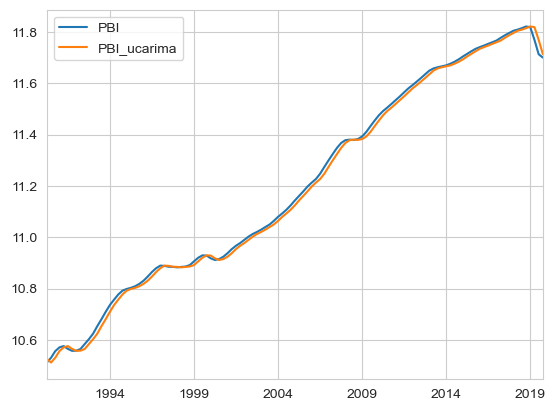

In [20]:
plt.figure()

y[1:].plot(label="PBI")
df.ucarima_hat[1:].plot(label="PBI_ucarima")
plt.legend()

plt.show()

#### 3. Filtro Hodrick-Prescott
El filtro es estimado medainte la siguiente estimacion:
$$ min_{\tau_t} = \sum_{t=1}^{T} c_t^2 + \lambda \sum_{t=1}^{T}[(\tau_t - \tau_{t-1}) - (\tau_{t-1} - \tau_{t-2})]^2$$

Donde $\lambda$ es un parametro de ajuste que por lo general toma los siguientes valores:

* Mensual: 129600
* Trimestral: 1600
* Anual: 6.25

In [25]:
hp_cycle, hp_hat = hp_filter.hpfilter(y, lamb=1600)

df["hp_hat"] = hp_hat
df["hp_cycle"] = hp_cycle

df.tail()

,pbi,pbi_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,hp_hat,hp_cycle
2018-10-01,11.829360,11.821777,116,11.844293,-0.022516,11.815159,0.006619,11.784677,0.037101
2019-01-01,11.835105,11.819252,117,11.855979,-0.036727,11.821777,-0.002525,11.785827,0.033425
2019-04-01,11.876294,11.769773,118,11.867665,-0.097892,11.819252,-0.049479,11.786710,-0.016937
2019-07-01,11.716217,11.713760,119,11.879351,-0.165591,11.769773,-0.056013,11.787438,-0.073678
2019-10-01,11.473594,11.700520,120,11.891038,-0.190518,11.713760,-0.013240,11.788111,-0.087591


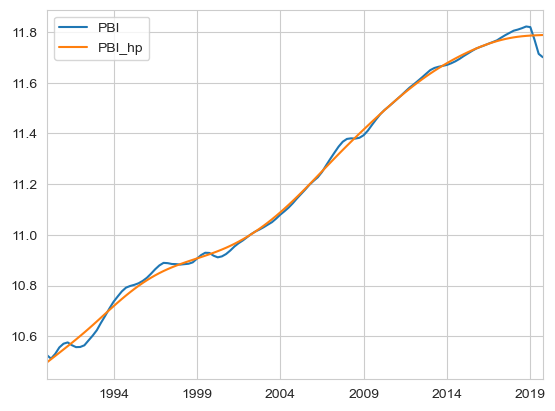

In [26]:
plt.figure()

y.plot(label="PBI")
df.hp_hat.plot(label="PBI_hp")
plt.legend()

plt.show()

#### 4. Filtro Baxter-King
Este filtro es particular, por que requiere se pierdan una cierta cantidad de valores al inicio y al final

In [27]:
bk_cycle = bk_filter.bkfilter(y)
bk_trend = y - bk_cycle

df["bk_trend"] = bk_trend
df["bk_cycle"] = bk_cycle

df.tail()

,pbi,pbi_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,hp_hat,hp_cycle,bk_trend,bk_cycle
2018-10-01,11.829360,11.821777,116,11.844293,-0.022516,11.815159,0.006619,11.784677,0.037101,NaN,NaN
2019-01-01,11.835105,11.819252,117,11.855979,-0.036727,11.821777,-0.002525,11.785827,0.033425,NaN,NaN
2019-04-01,11.876294,11.769773,118,11.867665,-0.097892,11.819252,-0.049479,11.786710,-0.016937,NaN,NaN
2019-07-01,11.716217,11.713760,119,11.879351,-0.165591,11.769773,-0.056013,11.787438,-0.073678,NaN,NaN
2019-10-01,11.473594,11.700520,120,11.891038,-0.190518,11.713760,-0.013240,11.788111,-0.087591,NaN,NaN


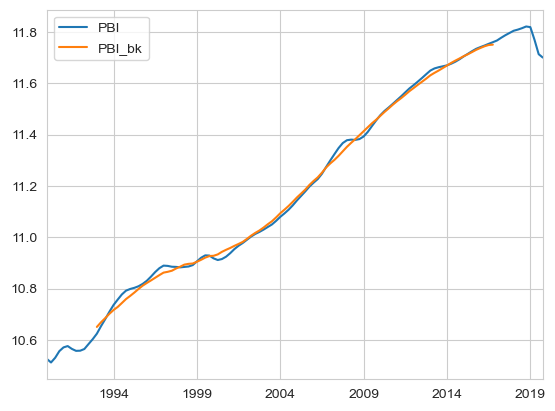

In [29]:
plt.figure()

y.plot(label="PBI")
df.bk_trend.plot(label="PBI_bk")
plt.legend()

plt.show()

#### 5. Filtro Christiano-Fitzgerald

In [30]:
cf_cycle, cf_hat = cf_filter.cffilter(y, drift=False)

df["cf_hat"] = cf_hat
df["cf_cycle"] = cf_cycle

df.tail()

,pbi,pbi_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,hp_hat,hp_cycle,bk_trend,bk_cycle,cf_hat,cf_cycle
2018-10-01,11.829360,11.821777,116,11.844293,-0.022516,11.815159,0.006619,11.784677,0.037101,NaN,NaN,11.763593,0.058185
2019-01-01,11.835105,11.819252,117,11.855979,-0.036727,11.821777,-0.002525,11.785827,0.033425,NaN,NaN,11.777325,0.041927
2019-04-01,11.876294,11.769773,118,11.867665,-0.097892,11.819252,-0.049479,11.786710,-0.016937,NaN,NaN,11.757032,0.012741
2019-07-01,11.716217,11.713760,119,11.879351,-0.165591,11.769773,-0.056013,11.787438,-0.073678,NaN,NaN,11.732628,-0.018868
2019-10-01,11.473594,11.700520,120,11.891038,-0.190518,11.713760,-0.013240,11.788111,-0.087591,NaN,NaN,11.741617,-0.041097


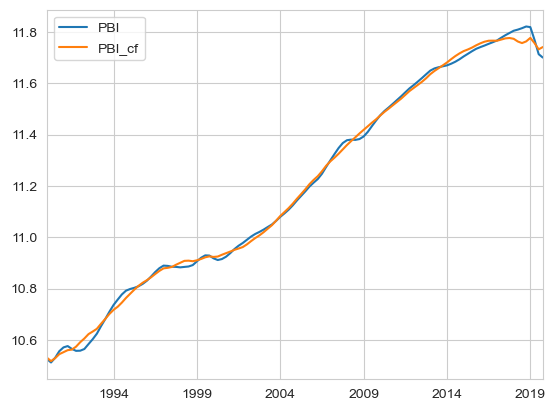

In [31]:
plt.figure()

y.plot(label="PBI")
df.cf_hat.plot(label="PBI_cf")
plt.legend()

plt.show()

#### Comparacion

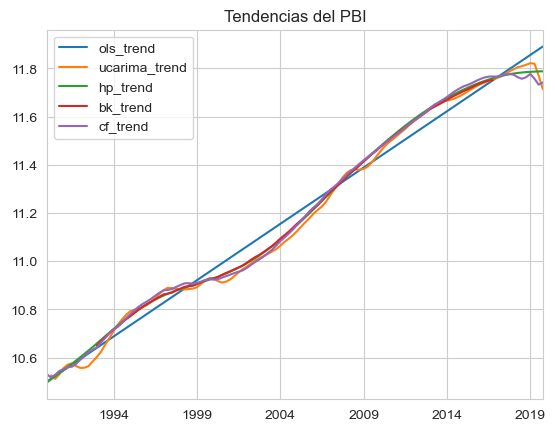

In [33]:
plt.figure()


df.ols_hat.plot(label="ols_trend")
df.ucarima_hat[1:].plot(label="ucarima_trend")
df.hp_hat.plot(label="hp_trend")
df.bk_trend.plot(label="bk_trend")
df.cf_hat.plot(label="cf_trend")

plt.title("Tendencias del PBI")
plt.legend()

plt.savefig("../figures/trends_pbi.pdf")
plt.show()

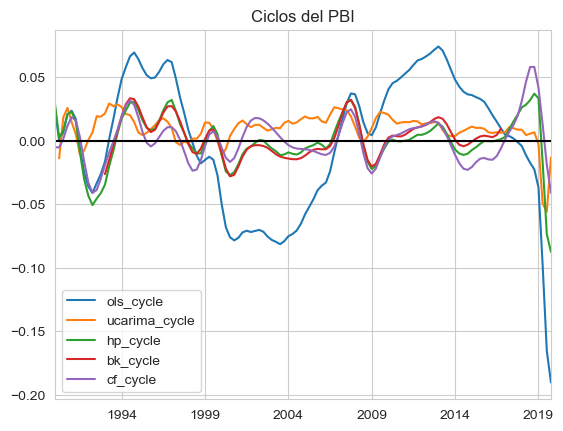

In [34]:
plt.figure()


df.ols_resid.plot(label="ols_cycle")
df.ucarima_resid[1:].plot(label="ucarima_cycle")
df.hp_cycle.plot(label="hp_cycle")
df.bk_cycle.plot(label="bk_cycle")
df.cf_cycle.plot(label="cf_cycle")

plt.axhline(y = 0, color = "black", linestyle = "-")
plt.title("Ciclos del PBI")
plt.legend()

plt.savefig("../figures/cycles_pbi.pdf")
plt.show()

#### Ciclos del PBI
Finalmente, se puede hacer un grafico conjunto para analizar cuales fueron los periodos donde el ciclo fue positivo o negativo. En este caso, tomare como referencia a los resultados del filtro HP

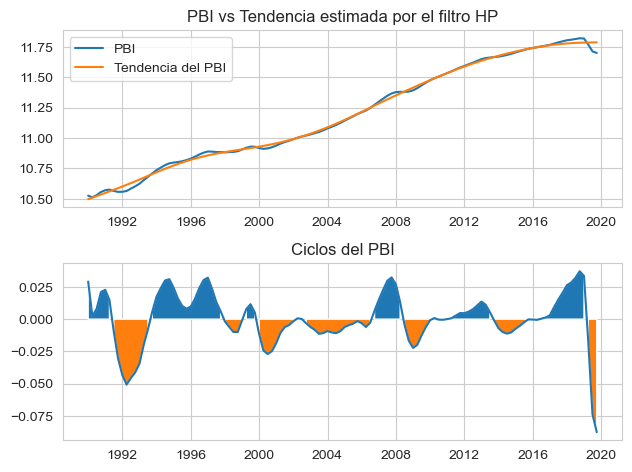

In [36]:
df_trend = pd.Series(index = y.index, data = hp_hat)
df_cycle = pd.Series(index = y.index, data = hp_cycle)

# Zero line
zero = [0 for t in hp_hat] 


fig, ax = plt.subplots(2, 1)

# Tendencias
ax[0].plot(y, label="PBI")
ax[0].plot(df_trend, label="Tendencia del PBI")

# Ciclos
ax[1].plot(df_cycle)
ax[1].fill_between(y.index,zero, df_cycle, where=df_cycle > 0)
ax[1].fill_between(y.index,zero, df_cycle, where=df_cycle < 0)

# Config
ax[0].set_title("PBI vs Tendencia estimada por el filtro HP")
ax[1].set_title("Ciclos del PBI")

ax[0].legend(loc="upper left")
plt.savefig("../figures/trend_cycle_pbi.pdf")

fig.tight_layout(pad=1)
plt.show()

#### Referencias
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.bk_filter.bkfilter.html#statsmodels.tsa.filters.bk_filter.bkfilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html#statsmodels.tsa.filters.hp_filter.hpfilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.cf_filter.cffilter.html#statsmodels.tsa.filters.cf_filter.cffilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose